In [ ]:
import numpy as np # linear algebra
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
sns.set_style('whitegrid') # set style for visualization
import warnings # ignore warnings
warnings.filterwarnings('ignore')
import requests, zipfile, io
from sklearn.impute import KNNImputer
import scipy as sp
from scipy import stats

# Loading Exercise Dataset


In [ ]:
url = "https://github.com/devtlv/Datasets-GEN-AI-Bootcamp/raw/refs/heads/main/Week%204/Day%202/Diabetes%20prediction%20dataset.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data")

In [6]:
df = pd.read_csv(r'C:\Repositories\DI-Bootcamp\Week11\Day4\ExercisesXP\data\diabetes_prediction_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


# Exercise 1: Understanding the problem and Data Collection

In [ ]:
# How Many Positive and Negative Cases are There?
count = df['diabetes'].value_counts()
negative = count[0]
positive = count[1]

print(f"Positive Cases: {positive}\nNegative Cases: {negative}")

Positive Cases: 8500
Negative Cases: 91500


In [21]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [ ]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

# Step 1: Separate Features (X) from Target (y)
X = df.drop('diabetes', axis=1)
Y = df['diabetes']

# Step 2: Split into Training and Testing Sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Step 3: Print the shapes of the new datasets to confirm the split
print("--- Split Results ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape:  {Y_test.shape}")


--- Split Results ---
X_train shape: (70000, 8)
X_test shape:  (30000, 8)
Y_train shape: (70000,)
Y_test shape:  (30000,)


# Exercise 2: Model Picking and Standardization

- Which classification model can we use in this problem and why?

We can use a Logistic Regression Model, it predicts the probability of occurrence of an event by fitting data to a logistic curve. It is widely used for classification problems where the outcomes are discrete (e.g., yes/no, 0/1).

- Do we need to standardize the data?

Yes. Generally  one should standardize the data before applying a Logistic Regression model, especially since this dataset includes continuous numerical features with varying scales (like age, BMI, or blood glucose levels).

In [24]:
# Standardize the Dataset to Prepare for Model
# Apply One-Hot Encoding to both training and test sets
# The 'dummy_na=False' is typically used to avoid creating a category for missing values.
X_train_encoded = pd.get_dummies(X_train, columns=['gender', 'smoking_history'], drop_first=False)
X_test_encoded = pd.get_dummies(X_test, columns=['gender', 'smoking_history'], drop_first=False)

# Crucial Step: Align Columns
# When OHE is done separately, the test set might be missing a category present in the train set.
# This ensures both DataFrames have the exact same columns after encoding.
common_cols = list(set(X_train_encoded.columns) & set(X_test_encoded.columns))

X_train_encoded = X_train_encoded[common_cols]
X_test_encoded = X_test_encoded[common_cols]

print("Shape after Encoding (Train):", X_train_encoded.shape)
print("Shape after Encoding (Test):", X_test_encoded.shape)

Shape after Encoding (Train): (70000, 15)
Shape after Encoding (Test): (30000, 15)


In [25]:
# Identify Scalable Columns After Encoding
scaling_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Standardize the Data
from sklearn.preprocessing import StandardScaler

# 1. Initialize the scaler
scaler = StandardScaler()

# 2. Fit the scaler ONLY on the training data's scaling columns
# This calculates the mean and standard deviation for the training data
scaler.fit(X_train_encoded[scaling_cols])

# 3. Transform both the training and testing sets
# Use the fitted scaler to transform the columns in place
X_train_encoded[scaling_cols] = scaler.transform(X_train_encoded[scaling_cols])
X_test_encoded[scaling_cols] = scaler.transform(X_test_encoded[scaling_cols])

print("\n--- Final Standardized Data Snapshot ---")
print("Train Data (First 5 rows, scaled columns will have mean ~0, std ~1):")
print(X_train_encoded[scaling_cols].head())
print("\n")
print("Test Data (First 5 rows, scaled columns):")
print(X_test_encoded[scaling_cols].head())


--- Final Standardized Data Snapshot ---
Train Data (First 5 rows, scaled columns will have mean ~0, std ~1):
            age       bmi  HbA1c_level  blood_glucose_level
54534  0.623757  1.835746    -1.430362            -0.936895
7286   0.978816  0.000155     1.000280            -1.183247
44496  0.313080  2.249846     0.439363             2.512030
86010  1.156345  0.000155    -0.682472            -1.306423
44954  0.890051  0.500086     0.158904             0.171688


Test Data (First 5 rows, scaled columns):
            age       bmi  HbA1c_level  blood_glucose_level
99961 -0.175126  0.046835    -1.430362             0.171688
28353 -0.130743  1.252995     0.626335             1.526623
82494 -0.352655  0.000155    -1.430362            -1.183247
78287  0.046786  0.000155    -1.897793            -0.197839
17812  0.890051  1.483385    -0.495500             1.526623


# Exercise 3 : Model Training

In [26]:
from sklearn.linear_model import LogisticRegression
# Create LogisticRegression Instance
model = LogisticRegression(random_state=42, solver='liblinear')

# Train the model using the prepared training data
# X_train_encoded contains the scaled numerical and one-hot encoded categorical features.
# y_train contains the target (diabetes 0/1) values.
model.fit(X_train_encoded, Y_train)
print("Logistic Regression Model training complete!")

Logistic Regression Model training complete!


# Exercise 4: Evaluation Metrics

In [ ]:
from sklearn.metrics import accuracy_score
# Plot the accuracy score and comment the results
# Make Predictions
Y_pred = model.predict(X_test_encoded)

# Determine Accuracy Score
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy Score: {accuracy:.4f}") 

Accuracy Score: 0.9602


Accuracy is the proportion of correct predictions among the total number of cases processed. In the above case, our model was able to correctly predict whether or not a patient has diabetes 96.02% of the time.

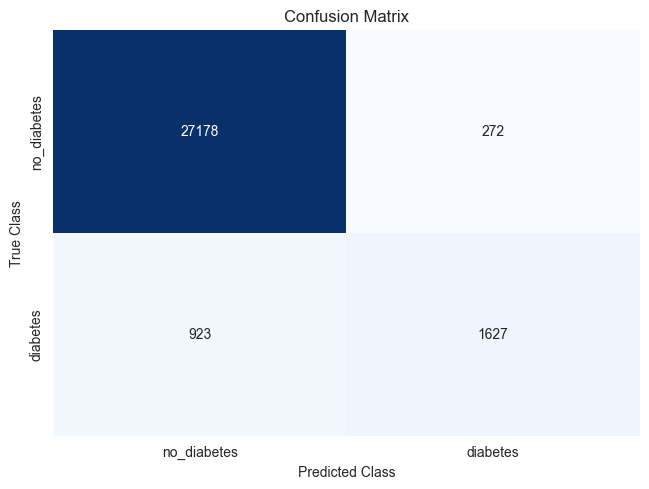

In [ ]:
from sklearn.metrics import confusion_matrix
# Plot the confusion matrix and comment the results.
class_names = ['no_diabetes', 'diabetes']
matrix = confusion_matrix(Y_test, Y_pred)

# Create pandas dataframe
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [36]:
# Results:
TP = 1627
TN = 27178
FP = 272
FN = 923

# Plot the Recall, Precision and F1 Scores
recall = TP / (TP + FN)
precision = TP / (TP + FP)
f1 = 2 * ((precision * recall)/(precision + recall))
accuracy = (TP + TN) / (TP + FP + TN + FN)

print("Accuracy:", accuracy)
print(f"Recall: {recall:.3f}\nPrecision: {precision:.3f}\nF1-Score: {f1:.3f}")

Accuracy: 0.9601666666666666
Recall: 0.638
Precision: 0.857
F1-Score: 0.731


# Exercise 6: ROC Curve

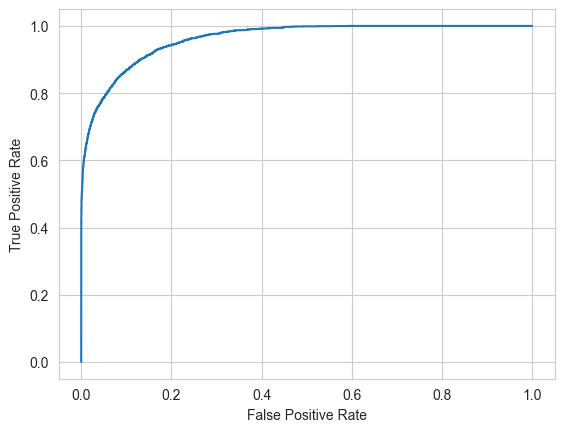

In [35]:
from sklearn import metrics

#define metrics
y_pred_proba = model.predict_proba(X_test_encoded)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()